<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [20]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd
import numpy as np

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.5


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [9]:
from fbprophet import Prophet

In [10]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [17]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df)

In [18]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.091778,-460.818755,-460.818755,2946.091771,2946.091784,2121.096363,2831.511611,-860.484941,-860.484941,-860.484941,399.666186,399.666186,399.666186,-460.818755,2485.273023
379,2016-01-17,1.076271,2949.096324,-303.307624,-303.307624,2949.096317,2949.096331,2279.064448,2997.347765,-720.184556,-720.184556,-720.184556,416.876932,416.876932,416.876932,-303.307624,2645.788700
380,2016-01-18,1.079096,2952.100870,714.117189,714.117189,2952.100863,2952.100878,3316.152659,4038.794940,282.582855,282.582855,282.582855,431.534334,431.534334,431.534334,714.117189,3666.218059
381,2016-01-19,1.081921,2955.105416,981.619602,981.619602,2955.105409,2955.105424,3556.377216,4305.847318,538.093426,538.093426,538.093426,443.526177,443.526177,443.526177,981.619602,3936.725019
382,2016-01-20,1.084746,2958.109962,874.491161,874.491161,2958.109954,2958.109971,3451.483676,4213.937193,421.712240,421.712240,421.712240,452.778920,452.778920,452.778920,874.491161,3832.601123


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [21]:
cmp_df = forecast[-predictions:].set_index('ds')[['yhat']].join(df[-predictions:].set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df['p'])), np.mean(abs(cmp_df['e']))

(38.38080483515084, 712.8566846748123)

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

## Предсказываем с помощью ARIMA

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return

In [75]:
data = train_df.set_index('ds')

Критерий Дики-Фуллера: p=0.107392


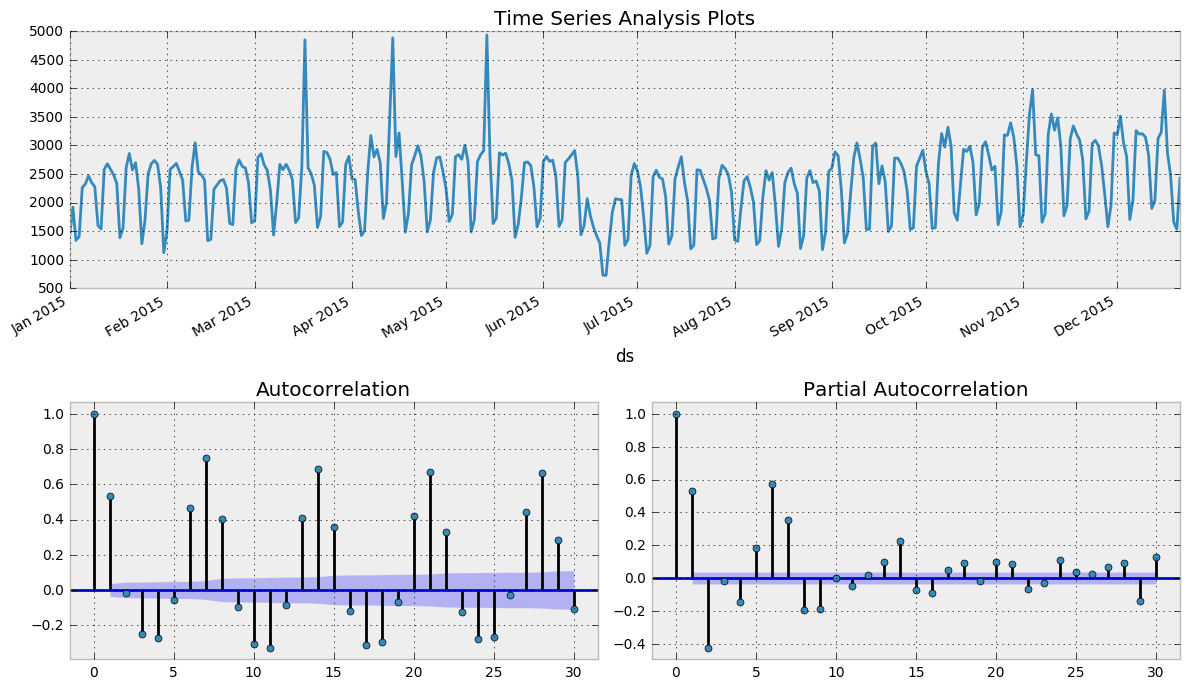

In [76]:
tsplot(data['y'], lags=30)

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [77]:
data['boxcox'], lmbda = stats.boxcox(data['y'])
data['boxcox'] = pd.Series(data['boxcox'])

Критерий Дики-Фуллера: p=0.116981
Оптимальный параметр преобразования Бокса-Кокса: 0.732841


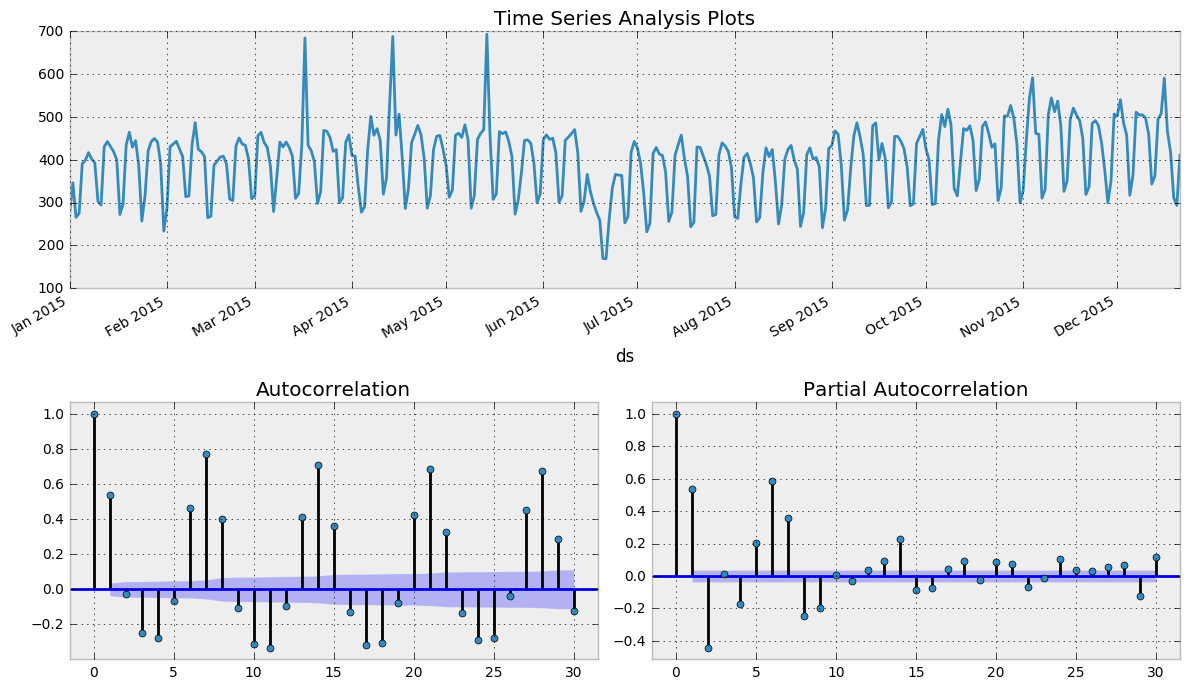

In [78]:
tsplot(data['boxcox'], lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

In [53]:
data_3 = data_2 - data_2.shift(7)

Критерий Дики-Фуллера: p=0.000000


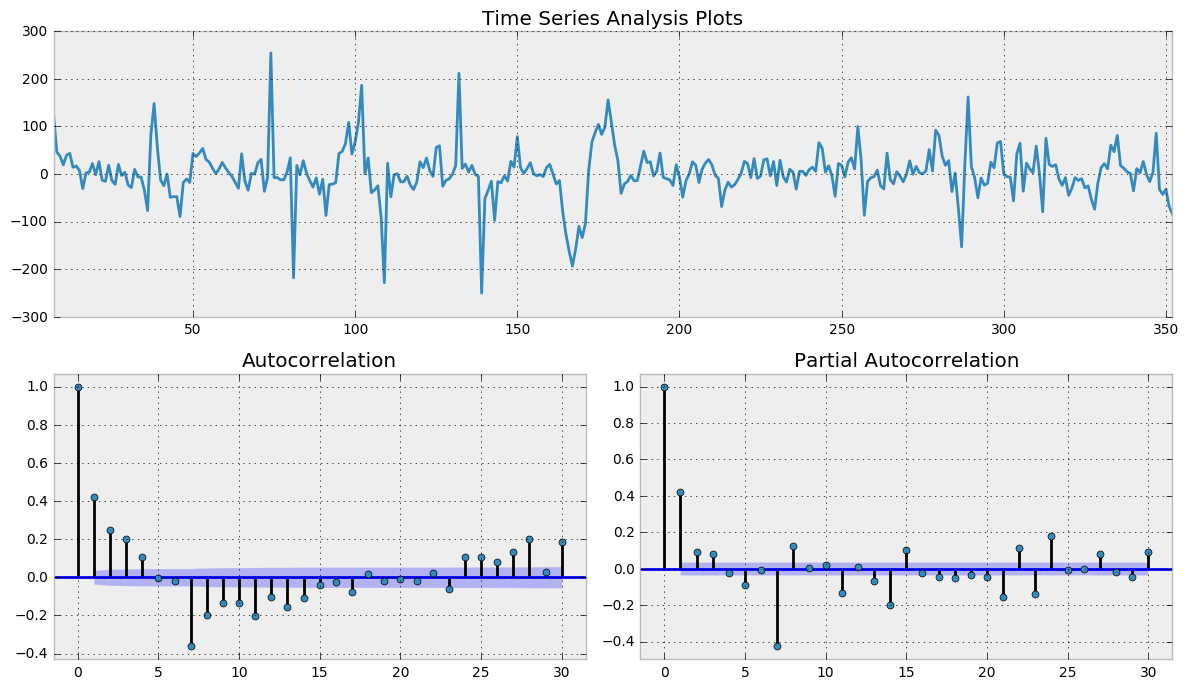

In [54]:
tsplot(data_3[7:], lags=30)

In [64]:
parameters_list = list([
    (1, 0, 2, 3, 0, 0),
    (1, 0, 2, 3, 1, 0),
    (1, 1, 2, 3, 1, 1),
    (1, 1, 2, 3, 2, 1)
])

In [86]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['boxcox'], order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

wrong parameters: (1, 0, 2, 3, 0, 0)
CPU times: user 14.7 s, sys: 409 ms, total: 15.1 s
Wall time: 15.3 s


In [87]:
best_aic

3534.5709482489337

In [88]:
best_param

(1, 1, 2, 3, 2, 1)

In [89]:
results

[[(1, 0, 2, 3, 1, 0), 3556.8800297985049],
 [(1, 1, 2, 3, 1, 1), 3557.9523643346038],
 [(1, 1, 2, 3, 2, 1), 3534.5709482489337]]